# Experimentos con Modelos de Lenguaje (Hiemstra LM) en pyTerrier

Se realizarán los mismos experimentos del ejercicio 7 del TP02 usando el modelo de lenguaje Hiemstra LM de pyTerrier, y se compararán los resultados con los obtenidos de TF-IDF.

In [1]:
import pyterrier as pt
import os
import matplotlib.pyplot as plt
import numpy as np

# Cargar dataset Vaswani
dataset = pt.datasets.get_dataset("vaswani")        # 11 429 docs, 93 queries, 2 083 qrels

# Indexar con IterDictIndexer
index_path = "./vaswani_index"
if os.path.exists(index_path + "/data.properties"):
    indexref = index_path + "/data.properties"
else:
    indexer = pt.index.IterDictIndexer(index_path)
    indexref = indexer.index(dataset.get_corpus_iter())

# Recuperadores
tfidf = pt.BatchRetrieve(indexref, wmodel="TF_IDF")
hiemstra = pt.BatchRetrieve(indexref, wmodel="Hiemstra_LM")

/tmp/ipykernel_57679/4258989903.py:18: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(indexref, wmodel="TF_IDF")
Java started (triggered by Retriever.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipykernel_57679/4258989903.py:19: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  hiemstra = pt.BatchRetrieve(indexref, wmodel="Hiemstra_LM")


## Experimentos Globales

Calculamos P@10, AP, nDCG@10 y la curva R-P para ambos modelos.

In [2]:
topics = dataset.get_topics()
qrels = dataset.get_qrels()

In [3]:
import IPython.display as disp

global_exp = pt.Experiment(
    [tfidf, hiemstra],
    topics,
    qrels,
    names=["TF-IDF", "Hiemstra_LM"],
    eval_metrics=["P_10", "map", "ndcg_cut_10"],
    perquery=False
)
disp.display(global_exp)

,name,P_10,map,ndcg_cut_10
0,TF-IDF,0.359140,0.290905,0.444411
1,Hiemstra_LM,0.321505,0.253518,0.394723


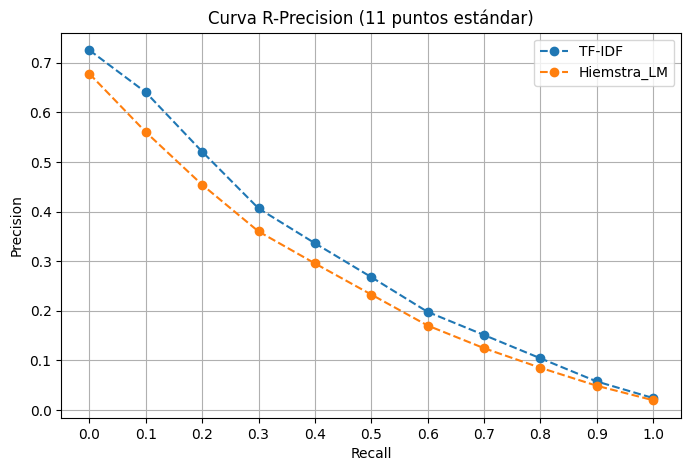

In [4]:
# Curva R-P para ambos modelos
recall_points = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
metrics = ["iprec_at_recall_0.00", "iprec_at_recall_0.10", "iprec_at_recall_0.20", "iprec_at_recall_0.30", "iprec_at_recall_0.40", "iprec_at_recall_0.50", "iprec_at_recall_0.60", "iprec_at_recall_0.70", "iprec_at_recall_0.80", "iprec_at_recall_0.90", "iprec_at_recall_1.00"]

pr_exp = pt.Experiment(
    [tfidf, hiemstra],
    topics,
    qrels,
    names=["TF-IDF", "Hiemstra_LM"],
    eval_metrics=metrics,
    perquery=False
)

precision_values_tfidf = [pr_exp.loc[pr_exp['name'] == 'TF-IDF', m].values[0] for m in metrics]   # Son un pandas.DataFrame
precision_values_hiemstra = [pr_exp.loc[pr_exp['name'] == 'Hiemstra_LM', m].values[0] for m in metrics]

plt.figure(figsize=(8,5))
for model, precision_values in zip(["TF-IDF", "Hiemstra_LM"], [precision_values_tfidf, precision_values_hiemstra]):
    plt.plot(
        recall_points,
        precision_values,
        marker='o',
        linestyle='--',
        label=model
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva R-Precision (11 puntos estándar)")
plt.grid(True)
plt.xticks(recall_points)
plt.legend()
plt.show()

In [5]:
print(pr_exp)

          name  iprec_at_recall_0.00  iprec_at_recall_0.10  \
0       TF-IDF              0.725414              0.640478   
1  Hiemstra_LM              0.677853              0.560311   

   iprec_at_recall_0.20  iprec_at_recall_0.30  iprec_at_recall_0.40  \
0              0.520824              0.406439              0.336222   
1              0.454073              0.359953              0.295518   

   iprec_at_recall_0.50  iprec_at_recall_0.60  iprec_at_recall_0.70  \
0              0.267922              0.197803              0.151191   
1              0.232761              0.170269              0.124608   

   iprec_at_recall_0.80  iprec_at_recall_0.90  iprec_at_recall_1.00  
0              0.104208              0.057509              0.024041  
1              0.085138              0.048896              0.019676  


## Experimentos Individuales (por query)

Calculamos las métricas para cada query y mostramos histogramas para comparar la distribución de los valores entre ambos modelos.

In [6]:
indv_exp = pt.Experiment(
    [tfidf, hiemstra],
    topics,
    qrels,
    names=["TF-IDF", "Hiemstra_LM"],
    eval_metrics=["P_10", "map", "ndcg_cut_10"],
    perquery=True
)

# Mostrar métricas para las primeras 3 queries de ambos modelos
for model in ["TF-IDF", "Hiemstra_LM"]:
    print(f"\nResultados para {model} (primeras 3 queries):")
    for qid in topics['qid'][:3]:
        query_text = topics.loc[topics['qid'] == qid, 'query'].values[0]
        p10 = indv_exp[(indv_exp['qid'] == str(qid)) & (indv_exp['name'] == model) & (indv_exp['measure'] == 'P_10')]['value'].values[0]
        ap = indv_exp[(indv_exp['qid'] == str(qid)) & (indv_exp['name'] == model) & (indv_exp['measure'] == 'map')]['value'].values[0]
        ndcg = indv_exp[(indv_exp['qid'] == str(qid)) & (indv_exp['name'] == model) & (indv_exp['measure'] == 'ndcg_cut_10')]['value'].values[0]
        print(f"Query = {query_text}")
        print(f"P@10 = {p10:.3f}")
        print(f"AP = {ap:.3f}")
        print(f"nDCG@10 = {ndcg:.3f}\n")


Resultados para TF-IDF (primeras 3 queries):
Query = measurement of dielectric constant of liquids by the use of microwave techniques
P@10 = 0.500
AP = 0.269
nDCG@10 = 0.574

Query = mathematical analysis and design details of waveguide fed microwave radiations
P@10 = 0.100
AP = 0.056
nDCG@10 = 0.095

Query = use of digital computers in the design of band pass filters having given phase and attenuation characteristics
P@10 = 0.300
AP = 0.239
nDCG@10 = 0.400


Resultados para Hiemstra_LM (primeras 3 queries):
Query = measurement of dielectric constant of liquids by the use of microwave techniques
P@10 = 0.400
AP = 0.217
nDCG@10 = 0.473

Query = mathematical analysis and design details of waveguide fed microwave radiations
P@10 = 0.100
AP = 0.055
nDCG@10 = 0.110

Query = use of digital computers in the design of band pass filters having given phase and attenuation characteristics
P@10 = 0.300
AP = 0.179
nDCG@10 = 0.269



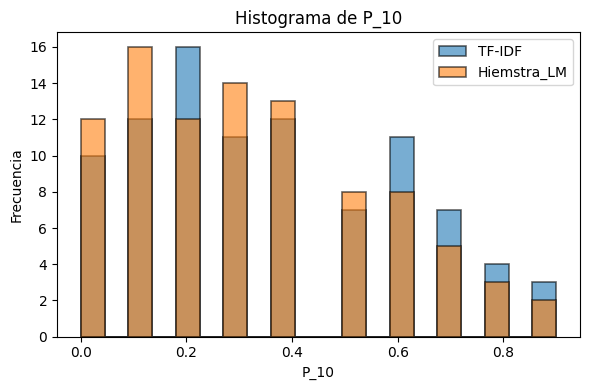

P_10 (TF-IDF) - media: 0.359, mediana: 0.300, desviación estándar: 0.250
P_10 (Hiemstra_LM) - media: 0.322, mediana: 0.300, desviación estándar: 0.237


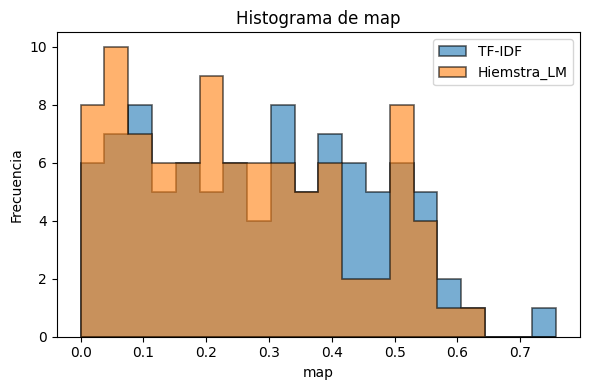

map (TF-IDF) - media: 0.291, mediana: 0.299, desviación estándar: 0.179
map (Hiemstra_LM) - media: 0.254, mediana: 0.234, desviación estándar: 0.171


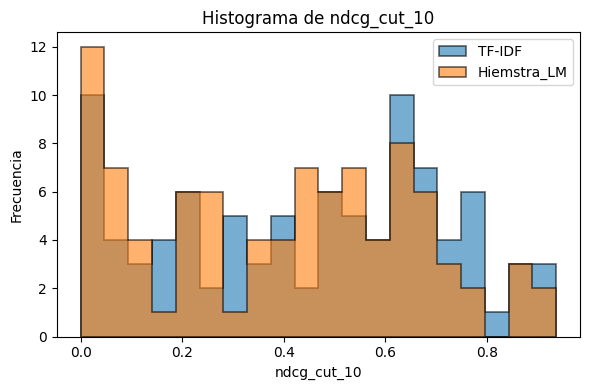

ndcg_cut_10 (TF-IDF) - media: 0.444, mediana: 0.489, desviación estándar: 0.274
ndcg_cut_10 (Hiemstra_LM) - media: 0.395, mediana: 0.436, desviación estándar: 0.261


In [8]:
metrics = ['P_10', 'map', 'ndcg_cut_10']
for metric in metrics:
    plt.figure(figsize=(6,4))
    # Obtener valores de ambos modelos para el mismo rango de bins
    values_tfidf = indv_exp[(indv_exp['name']=='TF-IDF') & (indv_exp['measure']==metric)]['value'].astype(float).values
    values_hiemstra = indv_exp[(indv_exp['name']=='Hiemstra_LM') & (indv_exp['measure']==metric)]['value'].astype(float).values
    all_values = np.concatenate([values_tfidf, values_hiemstra])
    bins = np.histogram_bin_edges(all_values, bins=20)  # Calcula los bins para ambos modelos, así se asegura de que ambos histogramas tengan el mismo rango (sino, pasaba que se superponían y se veía roto) -> por eso, vemos algunos bins vacíos
    plt.hist(values_tfidf, bins=bins, alpha=0.6, label='TF-IDF', edgecolor='black', linewidth=1.2, histtype='stepfilled')
    plt.hist(values_hiemstra, bins=bins, alpha=0.6, label='Hiemstra_LM', edgecolor='black', linewidth=1.2, histtype='stepfilled')
    plt.title(f'Histograma de {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.tight_layout()
    plt.show()
    for model_name, values in zip(['TF-IDF', 'Hiemstra_LM'], [values_tfidf, values_hiemstra]):
        print(f"{metric} ({model_name}) - media: {np.mean(values):.3f}, mediana: {np.median(values):.3f}, desviación estándar: {np.std(values):.3f}")